In [ ]:


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/nslkdd/kdd_train.csv
/kaggle/input/cicids2018/cicids2018.csv


In [2]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder, normalize
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE

# !pip install tensorflow==2.1.0
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout, Conv1D, MaxPool1D
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.losses import KLDivergence, mean_squared_error

import keras
from keras.utils import np_utils

In [3]:
df = pd.read_csv('../input/cicids2018/cicids2018.csv')
df.head(5)

Unnamed: 0  Dst Port  Protocol  Flow Duration  Tot Fwd Pkts  Tot Bwd Pkts  \
0           0         0         0      112641719             3             0   
1           1         0         0      112641466             3             0   
2           2         0         0      112638623             3             0   
3           3        22         6        6453966            15            10   
4           4        22         6        8804066            14            11   

   TotLen Fwd Pkts  TotLen Bwd Pkts  Fwd Pkt Len Max  Fwd Pkt Len Min  ...  \
0                0                0                0                0  ...   
1                0                0                0                0  ...   
2                0                0                0                0  ...   
3             1239             2273              744                0  ...   
4             1143             2209              744                0  ...   

   Fwd Seg Size Min  Active Mean  Active Std  Active Max  Active Min  \
0                 0          0.0         0.0           0           0   
1                 0          0.0         0.0           0           0   
2                 0          0.0         0.0           0           0   
3                32          0.0         0.0           0           0   
4                32          0.0         0.0           0           0   

    Idle Mean    Idle Std  Idle Max  Idle Min  Label  
0  56320859.5  139.300036  56320958  56320761      1  
1  56320733.0  114.551299  56320814  56320652      1  
2  56319311.5  301.934596  56319525  56319098      1  
3         0.0    0.000000         0         0      1  
4         0.0    0.000000         0         0      1  

[5 rows x 79 columns]

In [4]:
# #For NSL

# le = LabelEncoder()

# df['labels'] = le.fit_transform(df['labels'])
# df['protocol_type'] = le.fit_transform(df['protocol_type'])
# df['service'] = le.fit_transform(df['service'])
# df['flag'] = le.fit_transform(df['flag'])

In [5]:
#For NSL
# x = df.drop('labels', axis=1)
# y = df.loc[:, ['labels']]

#For cicids
x = df.drop('Label', axis=1)
y = df.loc[:, ['Label']]

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=.2, random_state=42)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_train = pd.DataFrame(X_train)
X_test = sc.fit_transform(X_test)
X_test = pd.DataFrame(X_test)

In [6]:
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

In [7]:
from sklearn.ensemble import RandomForestClassifier
m = RandomForestClassifier()
feature_dim=52
selector = RFE(m, n_features_to_select= feature_dim).fit(X_train,y_train)
indices = np.where(selector.support_==True)[0]
features = X_train.columns.values[indices]
X_train, X_test = X_train[features], X_test[features]

In [8]:
class HybridHuberLoss(tf.keras.losses.Loss):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    def call(self, y_true, y_pred):
        mse = mean_squared_error(y_true, y_pred)
        kld = KLDivergence()
        kld_loss = kld(y_true, y_pred)
        return tf.where(mse<kld_loss, kld_loss, mse)
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}

In [9]:
def LRschedulerCLF(epoch, lr=0.01):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

def LRschedulerAE(epoch):
    initial_lrate = 0.01
    drop = 0.005
    epochs_drop = 5.0
    lrate = initial_lrate * math.pow(drop,  
           math.floor((1+epoch)/epochs_drop))
    return lrate
    
clf_lr = tf.keras.callbacks.LearningRateScheduler(LRschedulerCLF)
ae_lr = tf.keras.callbacks.LearningRateScheduler(LRschedulerAE)

In [10]:
input_dim = X_train.shape[1]
encoding_dim = 32
ae_input_layer = Input(shape=(input_dim, ))

enc = Dense(64, activation="swish", activity_regularizer=regularizers.l1(10e-5))(ae_input_layer)
enc = BatchNormalization()(enc)
enc = Dense(encoding_dim, activation="swish")(enc)

dec = BatchNormalization()(enc)
dec = Dense(64, activation="swish")(dec)
dec = BatchNormalization()(enc)
dec = Dense(input_dim, activation="swish")(dec)

autoencoder = Model(inputs=ae_input_layer, outputs=dec)
encoder = Model(inputs=ae_input_layer, outputs=enc)

2022-03-24 19:40:16.122085: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-24 19:40:16.247150: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-24 19:40:16.247874: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-24 19:40:16.249002: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [11]:
ae_epoch = 2
batch_size = 32
autoencoder.compile(optimizer='adam', loss="mean_squared_error", metrics=['accuracy'])

In [12]:
history = autoencoder.fit(X_train, X_train, 
                    epochs=ae_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    callbacks = [ae_lr],
                    verbose=1).history

2022-03-24 19:40:19.915443: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/2
25000/25000 [==============================] - 71s 3ms/step - loss: 0.3386 - accuracy: 0.7193 - val_loss: 1.1286 - val_accuracy: 0.7719
Epoch 2/2
25000/25000 [==============================] - 71s 3ms/step - loss: 0.3514 - accuracy: 0.7709 - val_loss: 18.6299 - val_accuracy: 0.7169


In [13]:
encoder.trainable = False

input_layer = Input(shape=(feature_dim, ))

encoding = encoder(input_layer, training=False)

layer1 = Dense(64, activation="relu")(encoding)
layer1 = BatchNormalization()(layer1)
layer1 = Dropout(0.2)(layer1)

layer2 = Dense(64, activation="relu")(layer1)
layer2 = BatchNormalization()(layer2)
layer2 = Dropout(0.3)(layer2)

output_layer = Dense(11, activation="softmax")(layer2)

classifier = Model(inputs=input_layer ,outputs=output_layer)

In [14]:
classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'Precision', 'AUC'])

In [15]:
history = classifier.fit(X_train, y_train,
                    epochs=2,
                    batch_size=32,
                    shuffle=True,
                    validation_data=(X_test, y_test),
                    callbacks=[ae_lr],
                    verbose=1).history

Epoch 1/2
25000/25000 [==============================] - 121s 5ms/step - loss: 0.0782 - accuracy: 0.9743 - precision: 0.9755 - auc: 0.9989 - val_loss: 0.2030 - val_accuracy: 0.9734 - val_precision: 0.9735 - val_auc: 0.9987
Epoch 2/2
25000/25000 [==============================] - 121s 5ms/step - loss: 0.0542 - accuracy: 0.9839 - precision: 0.9842 - auc: 0.9992 - val_loss: 0.2072 - val_accuracy: 0.9697 - val_precision: 0.9698 - val_auc: 0.9955


In [16]:
temp_df = []
for row in X_test.itertuples(index=False):
    temp_df.extend([list(row)]*10)
    
tdf = pd.DataFrame(temp_df, columns=X_test.columns)
tdf

0         1         2         3         4         5         6   \
0        1.688504 -0.245231 -0.409377  0.017244  0.080693  1.959679 -0.278088   
1        1.688504 -0.245231 -0.409377  0.017244  0.080693  1.959679 -0.278088   
2        1.688504 -0.245231 -0.409377  0.017244  0.080693  1.959679 -0.278088   
3        1.688504 -0.245231 -0.409377  0.017244  0.080693  1.959679 -0.278088   
4        1.688504 -0.245231 -0.409377  0.017244  0.080693  1.959679 -0.278088   
...           ...       ...       ...       ...       ...       ...       ...   
1999995 -0.378492 -0.245231 -0.409377 -0.007814  0.041450 -0.128684 -0.326430   
1999996 -0.378492 -0.245231 -0.409377 -0.007814  0.041450 -0.128684 -0.326430   
1999997 -0.378492 -0.245231 -0.409377 -0.007814  0.041450 -0.128684 -0.326430   
1999998 -0.378492 -0.245231 -0.409377 -0.007814  0.041450 -0.128684 -0.326430   
1999999 -0.378492 -0.245231 -0.409377 -0.007814  0.041450 -0.128684 -0.326430   

               7         8         9   ...        54        55        62  \
0        2.503661  1.875183 -0.215537  ...  1.914085  4.208067  0.080693   
1        2.503661  1.875183 -0.215537  ...  1.914085  4.208067  0.080693   
2        2.503661  1.875183 -0.215537  ...  1.914085  4.208067  0.080693   
3        2.503661  1.875183 -0.215537  ...  1.914085  4.208067  0.080693   
4        2.503661  1.875183 -0.215537  ...  1.914085  4.208067  0.080693   
...           ...       ...       ...  ...       ...       ...       ...   
1999995 -0.146577  0.352628 -0.215537  ...  0.218490  0.199803  0.041450   
1999996 -0.146577  0.352628 -0.215537  ...  0.218490  0.199803  0.041450   
1999997 -0.146577  0.352628 -0.215537  ...  0.218490  0.199803  0.041450   
1999998 -0.146577  0.352628 -0.215537  ...  0.218490  0.199803  0.041450   
1999999 -0.146577  0.352628 -0.215537  ...  0.218490  0.199803  0.041450   

               63        64        65        66        67        68        69  
0       -0.278088  1.959679  2.503661 -0.383229  0.002696  0.062290 -0.391162  
1       -0.278088  1.959679  2.503661 -0.383229  0.002696  0.062290 -0.391162  
2       -0.278088  1.959679  2.503661 -0.383229  0.002696  0.062290 -0.391162  
3       -0.278088  1.959679  2.503661 -0.383229  0.002696  0.062290 -0.391162  
4       -0.278088  1.959679  2.503661 -0.383229  0.002696  0.062290 -0.391162  
...           ...       ...       ...       ...       ...       ...       ...  
1999995 -0.326430 -0.128684 -0.146577  2.999981 -0.131920  0.042667 -0.391162  
1999996 -0.326430 -0.128684 -0.146577  2.999981 -0.131920  0.042667 -0.391162  
1999997 -0.326430 -0.128684 -0.146577  2.999981 -0.131920  0.042667 -0.391162  
1999998 -0.326430 -0.128684 -0.146577  2.999981 -0.131920  0.042667 -0.391162  
1999999 -0.326430 -0.128684 -0.146577  2.999981 -0.131920  0.042667 -0.391162  

[2000000 rows x 52 columns]

In [17]:
import time

prcnt=[.25,.50,.75,1]
time_taken=[]
time_taken_per_packet=[]
for i in prcnt:
    print("For",i*100,"% of the test data")
    start=time.time()
    y_preds = classifier.predict(tdf[0:round(len(tdf)*i)])
    y_preds = np.round_(y_preds)
    end=time.time()
    tt=end-start
    norm=tt/round(len(tdf)*i)
    print("Time=",tt)
    print("Time per packet=",norm)
    time_taken_per_packet.append(norm)
    time_taken.append(tt)

For 25.0 % of the test data
Time= 17.159539699554443
Time per packet= 3.4319079399108885e-05
For 50.0 % of the test data
Time= 41.92784762382507
Time per packet= 4.192784762382507e-05
For 75.0 % of the test data
Time= 52.73759913444519
Time per packet= 3.515839942296346e-05
For 100 % of the test data


2022-03-24 19:49:14.679473: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 832000000 exceeds 10% of free system memory.
2022-03-24 19:49:15.637801: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 832000000 exceeds 10% of free system memory.


Time= 68.5605297088623
Time per packet= 3.428026485443115e-05


Text(0, 0.5, 'Time Taken')

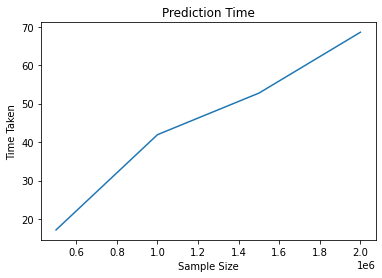

In [18]:
plt.plot([round(i*len(tdf)) for i in prcnt],time_taken)
plt.title("Prediction Time")
plt.xlabel("Sample Size")
plt.ylabel("Time Taken")